## Analysis of the world happiness report data

### Business Understanding:

Here, we will ask three questions:
    
    1) Is the notion of happiness same across different countries? If yes, what does it correspond to?
    
    2) Does the notion of happiness vary across regions?
    
    3) How does change in happiness over the years vary across the different regions?

### Data understanding

In [1]:
# All the essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_2015 = pd.read_csv('2015.csv')
df_2016 = pd.read_csv('2016.csv')
df_2017 = pd.read_csv('2017.csv')
df_2018 = pd.read_csv('2018.csv')
df_2019 = pd.read_csv('2019.csv')

# Let's look at what the data looks like\
df_2015.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


### Data preparation

In [4]:
# Let's rename the columns so that they all have the same names: 'score', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust',
# We don't include Dystopia factor in our analysis as it is only a benchmark value

df_2015.rename(columns = {'Happiness Score':'score', 'Economy (GDP per Capita)':'GDP', 
                          'Health (Life Expectancy)':'Health','Trust (Government Corruption)':'Trust'}, inplace = True)
df_2016.rename(columns = {'Happiness Score':'score', 'Economy (GDP per Capita)':'GDP', 
                          'Health (Life Expectancy)':'Health','Trust (Government Corruption)':'Trust'}, inplace = True)
df_2017.rename(columns = {'Happiness.Score':'score', 'Economy..GDP.per.Capita.':'GDP', 
                          'Health..Life.Expectancy.':'Health','Trust..Government.Corruption.':'Trust'}, inplace = True)
df_2018.rename(columns = {'Score':'score', 'GDP per Capita':'GDP', 'Freedom to make life choices':'Freedom', 
                          'Healthy life expectancy':'Health','Perceptions of corruption':'Trust', 'Social support': 'Family'}, inplace = True)
df_2019.rename(columns = {'Score':'score', 'GDP per capita':'GDP', 'Freedom to make life choices':'Freedom', 
                          'Healthy life expectancy':'Health','Perceptions of corruption':'Trust', 'Social support': 'Family'}, inplace = True)

# Let's only work with the 2015 dataset for this question.

df_to_use = df_2015
df_to_use.columns 

Index(['Country', 'Region', 'Happiness Rank', 'score', 'Standard Error', 'GDP',
       'Family', 'Health', 'Freedom', 'Trust', 'Generosity',
       'Dystopia Residual'],
      dtype='object')

In [5]:
#Let's check if there are any null value in the 2015 dataset!
df_to_use.isnull().any()


Country              False
Region               False
Happiness Rank       False
score                False
Standard Error       False
GDP                  False
Family               False
Health               False
Freedom              False
Trust                False
Generosity           False
Dystopia Residual    False
dtype: bool

### Data modeling

In [6]:
# Split into explanatory and response variables
X1 = df_to_use[['GDP','Family','Health','Freedom','Trust','Generosity']]
z_score_col = lambda col: (col - col.mean())/col.std() # Normalize column
X = X1.apply(z_score_col, axis=0) #z score the column values

y = df_to_use['score']

X.head()

,GDP,Family,Health,Freedom,Trust,Generosity
0,1.365280,1.316097,1.259404,1.572438,2.302331,0.469547
1,1.131628,1.509658,1.285347,1.328233,-0.016427,1.570862
2,1.189080,1.356740,0.989084,1.465001,2.833763,0.821680
3,1.520296,1.247954,1.031864,1.600044,1.846210,0.865884
4,1.191089,1.217334,1.114510,1.356104,1.550794,1.743021


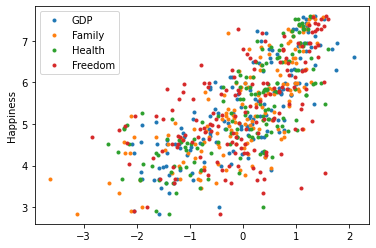

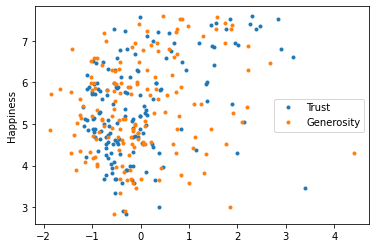

In [7]:
# Let's plot the different variables against the score to see if there's any trend!

plt.figure()
plt.plot(X.GDP, y,'.', label='GDP')
plt.plot(X.Family, y,'.', label='Family')
plt.plot(X.Health, y,'.', label='Health')
plt.plot(X.Freedom, y,'.', label='Freedom')
plt.ylabel('Happiness')
plt.legend()
plt.show()

plt.figure()
plt.plot(X.Trust, y,'.', label='Trust')
plt.plot(X.Generosity, y,'.', label='Generosity')
plt.ylabel('Happiness')
plt.legend()
plt.show()


The factors in the first plot above all seem to be correlated with happiness. Trust and Generosity seem less so. Let's check if our regression model confirms this.

### Evaluating the question:

In [8]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.8004656793512614 on 48 values.'

The variables are indeed very correlated with the happiness score. Let's see what the regression coefficients are.

In [10]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(7)

,est_int,coefs,abs_coefs
0,GDP,0.366070,0.366070
1,Family,0.322078,0.322078
2,Health,0.251560,0.251560
3,Freedom,0.183008,0.183008
5,Generosity,0.104388,0.104388
4,Trust,0.085448,0.085448


Indeed, looking at the coefficients, we can conclude that GDP, Family and Health are the top three contributors of happiness overall in the year 2015. What about the other years? Does it follow the same trend?

## Question 2
Let's now check if the results might be different for different regions in the world! We have the region information only for 2015 and 2016. For simplicity, let's look at 2015 results.

In [12]:
#The different regions are
df_reg = df_2016
df_reg.Region.unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa', 'Southern Asia'], dtype=object)

In [13]:
df_reg.groupby('Region').Region.count()

Region
Australia and New Zealand           2
Central and Eastern Europe         29
Eastern Asia                        6
Latin America and Caribbean        24
Middle East and Northern Africa    19
North America                       2
Southeastern Asia                   9
Southern Asia                       7
Sub-Saharan Africa                 38
Western Europe                     21
Name: Region, dtype: int64

In [16]:
# We see that some regions have very few countries; so let's try to group them! Perhaps, we can group them together
# by what seem like similar cultures.

# Australia and New Zealand and North America, let's group them with Western Europe and call it West
df4 = df_reg
df4 = df4.replace(to_replace='Australia and New Zealand', value='West')
df4 = df4.replace(to_replace='North America', value='West')
df4 = df4.replace(to_replace='Western Europe', value='West')
#df4 = df4.replace(to_replace='Middle East and Northern Africa', value='Middle East and Africa')
#df4 = df4.replace(to_replace='Sub-Saharan Africa', value='Middle East and Africa')

# Let's also group South eastern, Southern and Eastern Asia together
df4 = df4.replace(to_replace='Southeastern Asia', value='Asia')
df4 = df4.replace(to_replace='Southern Asia', value='Asia')
df4 = df4.replace(to_replace='Eastern Asia', value='Asia')

df2 = df4.groupby('Region').score.mean() # A series with the region and the mean happiness of that region
df4.groupby('Region').Region.count()


Region
Asia                               22
Central and Eastern Europe         29
Latin America and Caribbean        24
Middle East and Northern Africa    19
Sub-Saharan Africa                 38
West                               25
Name: Region, dtype: int64

In [18]:
#Use the function
df_to_use = df4
Region_1 =[]; Region_2 =[]; Region_3 =[]; Region_1_coef =[]; Region_2_coef =[]; Region_3_coef =[]; 
for region in df4.Region.unique():
    df_to_use = df4[df4.Region ==region]
    coef_df = coef_weights(df_to_use)
    #A quick look at the top results
    Region_1.append(list(coef_df.est_int[0:1])[0])
    Region_2.append(list(coef_df.est_int[1:2])[0])
    Region_3.append(list(coef_df.est_int[2:3])[0])
    Region_1_coef.append(round(float(coef_df.coefs[0:1]),2))
    Region_2_coef.append(round(float(coef_df.coefs[1:2]),2))
    Region_3_coef.append(round(float(coef_df.coefs[2:3]),2))

df3 = pd.DataFrame(df2)   
df3["Factor 1"] = Region_1
df3["coeff 1"] = Region_1_coef
df3["Factor 2"] = Region_2
df3["coeff 2"] = Region_2_coef
df3["Factor 3"] = Region_3
df3["coeff 3"] = Region_3_coef
df3

,score,Factor 1,coeff 1,Factor 2,coeff 2,Factor 3,coeff 3
Region,,,,,,,
Asia,5.169909,Family,0.27,Freedom,0.23,Trust,0.14
Central and Eastern Europe,5.370690,GDP,0.77,Family,0.41,Generosity,-0.40
Latin America and Caribbean,6.101750,GDP,0.46,Health,0.20,Trust,0.08
Middle East and Northern Africa,5.386053,Family,0.41,GDP,0.30,Freedom,-0.19
Sub-Saharan Africa,4.136421,GDP,0.39,Health,-0.30,Trust,-0.21
West,6.782160,Generosity,0.31,GDP,0.27,Health,-0.11


The top three factors that correlate with happiness seem to vary for the different regions. It seems like in Asia and Middle East and Northern Africa, countries with more family support are more happy whereas in Central Europe, Latin America and Sub-Saharan Africa, richer countries are more happy. In the West, countries with more generosity in the population seem happier. 

Note, these results were performed on a very small sample size, so they may not be very accurate. But it's nevertheless interesting to see different trends. Note also that some of the coefficients are negative, which are hard to explain.

## Question 3
Let's now check how the results change over the years (from 2015 to 2016) i.e. let's try to correlate the change in happiness score to the change in the other scores for the same regions. The question is: do countries in a certain region become happier/unhappier because of the same reason as above i.e. for example, if family score improves in Asia, do the countries in the region tend to become more happy?

In [19]:
#The different regions are
df_reg1 = df_2015
df_reg2 = df_2016


df1 = df_reg1
df1 = df1.replace(to_replace='Australia and New Zealand', value='West')
df1 = df1.replace(to_replace='North America', value='West')
df1 = df1.replace(to_replace='Western Europe', value='West')
#df1 = df1.replace(to_replace='Middle East and Northern Africa', value='Middle East and Africa')
#df1 = df1.replace(to_replace='Sub-Saharan Africa', value='Middle East and Africa')
df1 = df1.replace(to_replace='Southeastern Asia', value='Asia')
df1 = df1.replace(to_replace='Southern Asia', value='Asia')
df1 = df1.replace(to_replace='Eastern Asia', value='Asia')


df2 = df_reg2
df2 = df2.replace(to_replace='Australia and New Zealand', value='West')
df2 = df2.replace(to_replace='North America', value='West')
df2 = df2.replace(to_replace='Western Europe', value='West')
#df2 = df2.replace(to_replace='Middle East and Northern Africa', value='Middle East and Africa')
#df2 = df2.replace(to_replace='Sub-Saharan Africa', value='Middle East and Africa')
df2 = df2.replace(to_replace='Southeastern Asia', value='Asia')
df2 = df2.replace(to_replace='Southern Asia', value='Asia')
df2 = df2.replace(to_replace='Eastern Asia', value='Asia')

df1_sc = df1.groupby('Region').score.mean()
df2_sc = df2.groupby('Region').score.mean()

df3 = df1[['Country','Region', 'score', 'GDP', 'Family', 'Health', 'Freedom','Trust', 'Generosity']]
df4 = df2[['Country','Region', 'score', 'GDP', 'Family', 'Health', 'Freedom','Trust', 'Generosity']]
df5 = df4.set_index(['Region','Country']).subtract(df3.set_index(['Region','Country']), fill_value=0)


df5.head()

score      GDP   Family   Health  Freedom    Trust  \
Region Country                                                           
Asia   Afghanistan -0.215  0.06245 -0.19248 -0.12991 -0.06984 -0.02607   
       Bangladesh  -0.051  0.14424 -0.18357 -0.07175 -0.01042  0.00014   
       Bhutan      -0.057  0.08228 -0.19559 -0.07648 -0.07132  0.00715   
       Cambodia     0.088  0.09566 -0.08986 -0.18620 -0.07394  0.00845   
       China        0.105  0.13768 -0.15294 -0.08097 -0.07685 -0.00036   

                    Generosity  
Region Country                  
Asia   Afghanistan    -0.05242  
       Bangladesh     -0.02090  
       Bhutan          0.00548  
       Cambodia       -0.00020  
       China          -0.03226

In [21]:
#Use the function
df_mean = df5.groupby('Region').score.mean()
df_to_use = df5
Region_1 =[]; Region_2 =[]; Region_3 =[]; Region_1_coef =[]; Region_2_coef =[]; Region_3_coef =[]; 
for region in df4.Region.unique():
    df_to_use = df4[df4.Region ==region]
    coef_df = coef_weights(df_to_use)
    #A quick look at the top results
    Region_1.append(list(coef_df.est_int[0:1])[0])
    Region_2.append(list(coef_df.est_int[1:2])[0])
    Region_3.append(list(coef_df.est_int[2:3])[0])
    Region_1_coef.append(round(float(coef_df.coefs[0:1]),2))
    Region_2_coef.append(round(float(coef_df.coefs[1:2]),2))
    Region_3_coef.append(round(float(coef_df.coefs[2:3]),2))

df_new = pd.DataFrame(df_mean)   
df_new["Factor 1"] = Region_1
df_new["coeff 1"] = Region_1_coef
df_new["Factor 2"] = Region_2
df_new["coeff 2"] = Region_2_coef
df_new["Factor 3"] = Region_3
df_new["coeff 3"] = Region_3_coef
df_new

,score,Factor 1,coeff 1,Factor 2,coeff 2,Factor 3,coeff 3
Region,,,,,,,
Asia,0.002636,Family,0.27,Freedom,0.23,Trust,0.14
Central and Eastern Europe,0.037759,GDP,0.77,Family,0.41,Generosity,-0.40
Latin America and Caribbean,0.469125,GDP,0.46,Health,0.20,Trust,0.08
Middle East and Northern Africa,-0.290150,Family,0.41,GDP,0.30,Freedom,-0.19
Sub-Saharan Africa,-0.248364,GDP,0.39,Health,-0.30,Trust,-0.21
West,-0.001760,Generosity,0.31,GDP,0.27,Health,-0.11


It seems indeed that the change in happiness is related to the change in the same factors as in the previous
question. We could extend this analysis to different years by adding a region column to the other datasets. It could also be interesting to study the relative change in happiness/different factors across the regions rather than the absolute changes. 